<a href="https://colab.research.google.com/github/OliverMaerz/Covid-19/blob/master/Covid19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 - New Cases, Deaths, Recovered - Death Rate - Reproduction Number (R)

Generated with data from Johns Hopkins CSSE: https://github.com/CSSEGISandData




Set the list of countries we want to take a look at:

In [29]:
# selected_countries = ['Argentina', 'Spain', 'Italy', 'Brazil', 'Chile', 
#                        'Germany', 'US', 'France', 'United Kingdom']

selected_countries = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Peru']


First: Download the Johns Hopkins CSSE global dataset for Covid-19:

In [30]:
!curl -o confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!curl -o deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
!curl -o recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  189k  100  189k    0     0  2525k      0 --:--:-- --:--:-- --:--:-- 2525k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  135k  100  135k    0     0  2024k      0 --:--:-- --:--:-- --:--:-- 2024k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  165k  100  165k    0     0  2362k      0 --:--:-- --:--:-- --:--:-- 2397k


Next: Import the libraries we will use for data wrangling and display:

In [31]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [40, 20]
import numpy as np
import pandas as pd

Load the downloaded dataset (csv files) into [Pandas](https://pandas.pydata.org/) dataframes and remove columns we do not need:

In [32]:
confirmed_df = pd.read_csv('confirmed.csv', sep=',', header=0, 
                           error_bad_lines=False)
deaths_df = pd.read_csv('deaths.csv', sep=',', header=0, 
                        error_bad_lines=False)
recovered_df = pd.read_csv('recovered.csv', sep=',', header=0, 
                           error_bad_lines=False)

Define helper functions

In [33]:
# Get a new dataframe with only the countries that are in the 
# selected_countries list and drop the rest
def get_selected_countries(df):
    selected_df = df.loc[df['Country/Region'].isin(selected_countries) & \
                         df['Province/State'].isnull()].copy()
    selected_df.set_index('Country/Region', inplace=True)
    # drop some columns we will no longer need
    selected_df.drop(['Lat', 'Long', 'Province/State'], axis=1, inplace=True)
    # convert the column names to date-time format
    selected_df.columns = pd.to_datetime(selected_df.columns)
    return selected_df


# Get the new cases, deaths, or recovered cases by calculating the difference
# to the previous days for each day
def get_difference_between_days(df):
    diff_df = df.diff(axis=1)
    # drop the first column as there is no previous day to calculate the 
    # difference 
    diff_df.drop(diff_df.columns[0], axis='columns', inplace=True)
    # drop any zero colums
    diff_df = diff_df.loc[:, (diff_df != 0).any(axis=0)]
    # get rid of negative values
    diff_df[diff_df < 0] = 0
    return diff_df
     

## Create dataframe with selected countries and new confirmed cases per day

In [34]:
selected_confirmed_df = get_selected_countries(confirmed_df)
new_confirmed_df = get_difference_between_days(selected_confirmed_df)
new_confirmed_df

,2020-02-23,2020-02-26,2020-02-29,2020-03-01,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,...,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,6.0,4.0,0.0,5.0,2.0,0.0,12.0,3.0,11.0,11.0,12.0,11.0,18.0,31.0,30.0,108.0,35.0,86.0,0.0,115.0,87.0,101.0,55.0,75.0,234.0,0.0,79.0,132.0,186.0,0.0,103.0,74.0,...,1393.0,1958.0,2060.0,1634.0,1581.0,2146.0,2272.0,2648.0,2606.0,2886.0,2401.0,2189.0,2335.0,2262.0,2667.0,2744.0,2845.0,2590.0,2439.0,2632.0,2979.0,3604.0,3663.0,3367.0,3449.0,2657.0,3099.0,3645.0,4236.0,3637.0,4518.0,3223.0,4231.0,4019.0,5344.0,5782.0,6127.0,5493.0,4814.0,4192.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,7.0,0.0,1.0,0.0,1.0,0.0,3.0,4.0,5.0,3.0,2.0,3.0,11.0,18.0,13.0,7.0,16.0,10.0,8.0,8.0,9.0,7.0,18.0,26.0,11.0,...,802.0,814.0,977.0,1036.0,876.0,1105.0,896.0,1098.0,1016.0,920.0,1253.0,848.0,601.0,1094.0,1008.0,1301.0,1290.0,1253.0,1226.0,1212.0,1036.0,1439.0,1129.0,1452.0,1635.0,987.0,1063.0,1617.0,1351.0,1938.0,1946.0,2036.0,1444.0,1409.0,1366.0,1778.0,1117.0,1204.0,1825.0,1148.0
Brazil,0.0,1.0,1.0,0.0,0.0,2.0,0.0,9.0,0.0,7.0,5.0,6.0,7.0,14.0,99.0,0.0,11.0,38.0,121.0,51.0,249.0,172.0,228.0,525.0,378.0,323.0,307.0,431.0,432.0,487.0,352.0,323.0,1138.0,1119.0,1208.0,1012.0,1304.0,770.0,1031.0,1873.0,...,32188.0,22765.0,54771.0,34666.0,15762.0,23129.0,39436.0,42725.0,39483.0,46860.0,38693.0,30476.0,24052.0,33846.0,46712.0,48105.0,42223.0,37923.0,26051.0,20229.0,45305.0,44571.0,42619.0,45048.0,39023.0,24831.0,20286.0,41857.0,39924.0,45403.0,34177.0,28532.0,23529.0,20257.0,41008.0,67860.0,59961.0,55891.0,51147.0,24578.0
Chile,2.0,0.0,0.0,7.0,1.0,0.0,3.0,0.0,0.0,7.0,0.0,5.0,10.0,0.0,20.0,33.0,13.0,81.0,46.0,37.0,0.0,196.0,131.0,95.0,114.0,176.0,220.0,164.0,304.0,350.0,230.0,310.0,289.0,293.0,373.0,333.0,512.0,310.0,344.0,301.0,...,1900.0,4475.0,6290.0,5355.0,5607.0,4608.0,3804.0,3649.0,4648.0,4296.0,4406.0,4216.0,4017.0,3394.0,2650.0,2498.0,3548.0,3758.0,3685.0,3025.0,2462.0,2064.0,3133.0,3058.0,2755.0,3012.0,2616.0,1836.0,1712.0,2493.0,2741.0,2407.0,2084.0,2099.0,1654.0,1719.0,2357.0,2545.0,2288.0,2198.0
Peru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,4.0,0.0,4.0,13.0,10.0,5.0,43.0,31.0,28.0,89.0,0.0,84.0,45.0,32.0,21.0,64.0,100.0,55.0,36.0,181.0,98.0,115.0,258.0,91.0,181.0,151.0,535.0,280.0,393.0,...,3752.0,3480.0,3537.0,3413.0,3598.0,2511.0,3363.0,3879.0,3913.0,3762.0,3625.0,3430.0,2946.0,2848.0,3264.0,3527.0,3595.0,3481.0,3638.0,2985.0,3575.0,3633.0,3537.0,3198.0,3064.0,3616.0,3797.0,3744.0,3884.0,3835.0,3951.0,3963.0,4090.0,4091.0,4406.0,4463.0,4546.0,4865.0,0.0,0.0


## Plot new confirmed cases per day

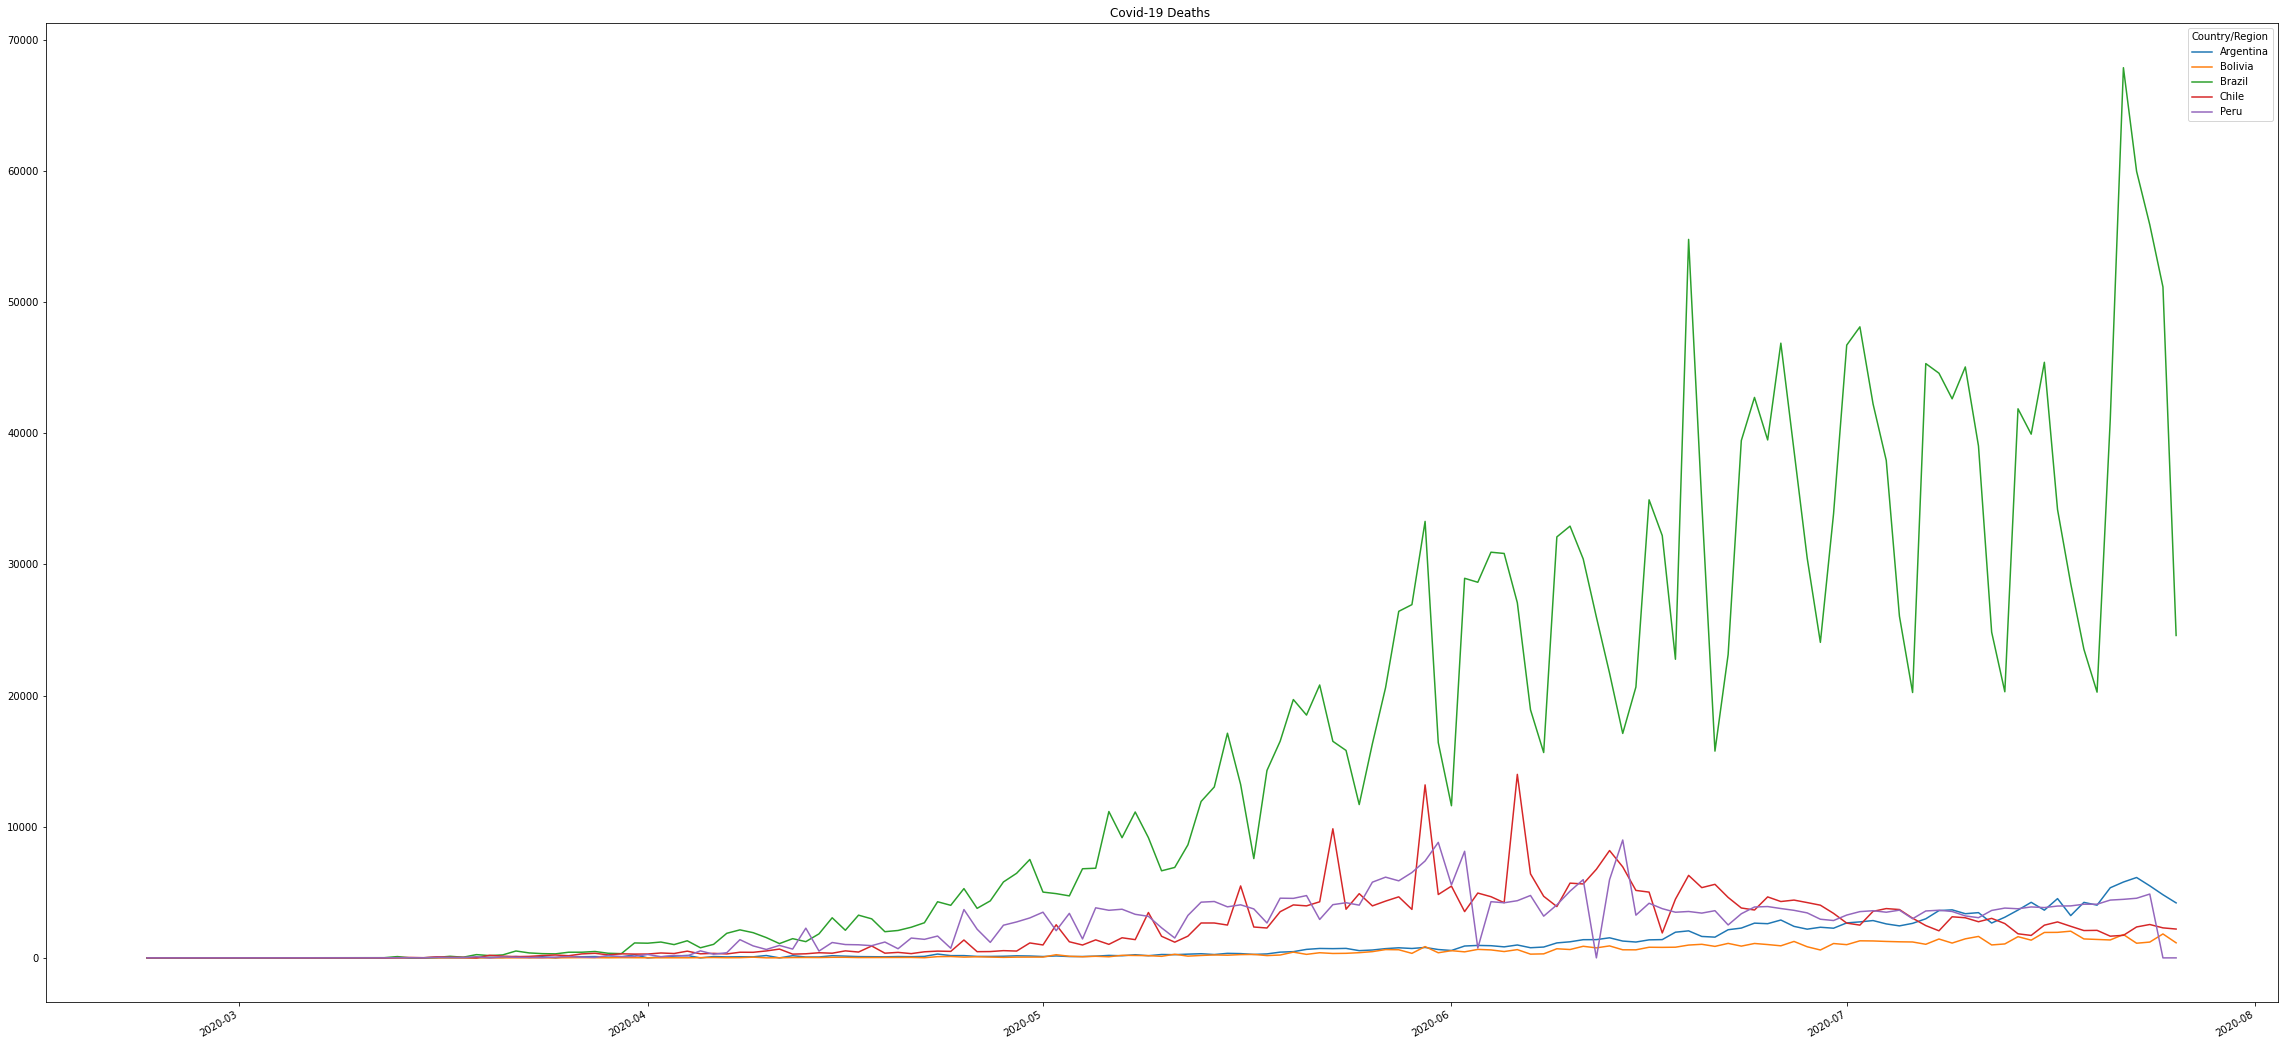

In [35]:
new_confirmed_df.transpose().plot(kind='line', title='Covid-19 Deaths ', 
                                  logy=False)

## Create dataframe with selected countries and number of deaths per day

In [36]:
selected_deaths_df = get_selected_countries(deaths_df)
new_deaths_df = get_difference_between_days(selected_deaths_df)
new_deaths_df

,2020-03-08,2020-03-13,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,...,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,4.0,5.0,1.0,4.0,4.0,1.0,8.0,3.0,4.0,1.0,4.0,8.0,7.0,9.0,10.0,1.0,7.0,7.0,5.0,9.0,4.0,8.0,6.0,3.0,4.0,11.0,5.0,13.0,...,35.0,35.0,31.0,13.0,19.0,32.0,35.0,38.0,34.0,34.0,23.0,25.0,48.0,27.0,44.0,34.0,52.0,44.0,26.0,75.0,62.0,50.0,26.0,54.0,36.0,35.0,58.0,65.0,82.0,62.0,66.0,42.0,40.0,113.0,117.0,98.0,114.0,105.0,86.0,46.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,3.0,1.0,1.0,4.0,3.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,3.0,6.0,...,20.0,18.0,18.0,25.0,33.0,47.0,26.0,30.0,37.0,21.0,36.0,44.0,57.0,52.0,78.0,70.0,49.0,58.0,56.0,42.0,54.0,47.0,61.0,64.0,52.0,53.0,59.0,32.0,44.0,42.0,65.0,57.0,45.0,67.0,55.0,55.0,79.0,66.0,62.0,48.0
Brazil,0.0,0.0,1.0,2.0,3.0,5.0,4.0,10.0,9.0,12.0,13.0,18.0,15.0,19.0,25.0,23.0,42.0,39.0,84.0,35.0,86.0,41.0,78.0,122.0,133.0,131.0,107.0,67.0,99.0,105.0,204.0,204.0,188.0,217.0,213.0,108.0,125.0,154.0,165.0,425.0,...,1269.0,1238.0,1206.0,1022.0,615.0,680.0,1374.0,1185.0,1141.0,990.0,1109.0,552.0,692.0,1280.0,1038.0,1252.0,1290.0,1091.0,602.0,620.0,1254.0,1223.0,1220.0,1214.0,1071.0,631.0,733.0,1300.0,1233.0,1322.0,1163.0,921.0,716.0,632.0,1367.0,1284.0,1311.0,1156.0,1211.0,555.0
Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,2.0,4.0,5.0,7.0,3.0,6.0,5.0,9.0,8.0,8.0,7.0,2.0,10.0,2.0,11.0,11.0,10.0,7.0,6.0,8.0,13.0,8.0,...,232.0,226.0,252.0,202.0,184.0,23.0,3.0,226.0,172.0,165.0,279.0,162.0,66.0,113.0,65.0,167.0,131.0,141.0,116.0,76.0,50.0,139.0,109.0,99.0,100.0,98.0,45.0,45.0,117.0,104.0,1057.0,98.0,58.0,130.0,44.0,45.0,116.0,76.0,106.0,92.0
Peru,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,5.0,2.0,6.0,6.0,8.0,17.0,6.0,12.0,10.0,9.0,15.0,14.0,17.0,31.0,12.0,12.0,23.0,14.0,24.0,20.0,26.0,48.0,52.0,45.0,39.0,46.0,42.0,...,201.0,204.0,199.0,201.0,184.0,178.0,181.0,182.0,175.0,178.0,196.0,182.0,187.0,173.0,183.0,185.0,181.0,186.0,177.0,183.0,180.0,181.0,181.0,186.0,182.0,188.0,184.0,175.0,188.0,198.0,184.0,199.0,189.0,197.0,195.0,188.0,3887.0,189.0,0.0,0.0


## Plot number of deaths per day

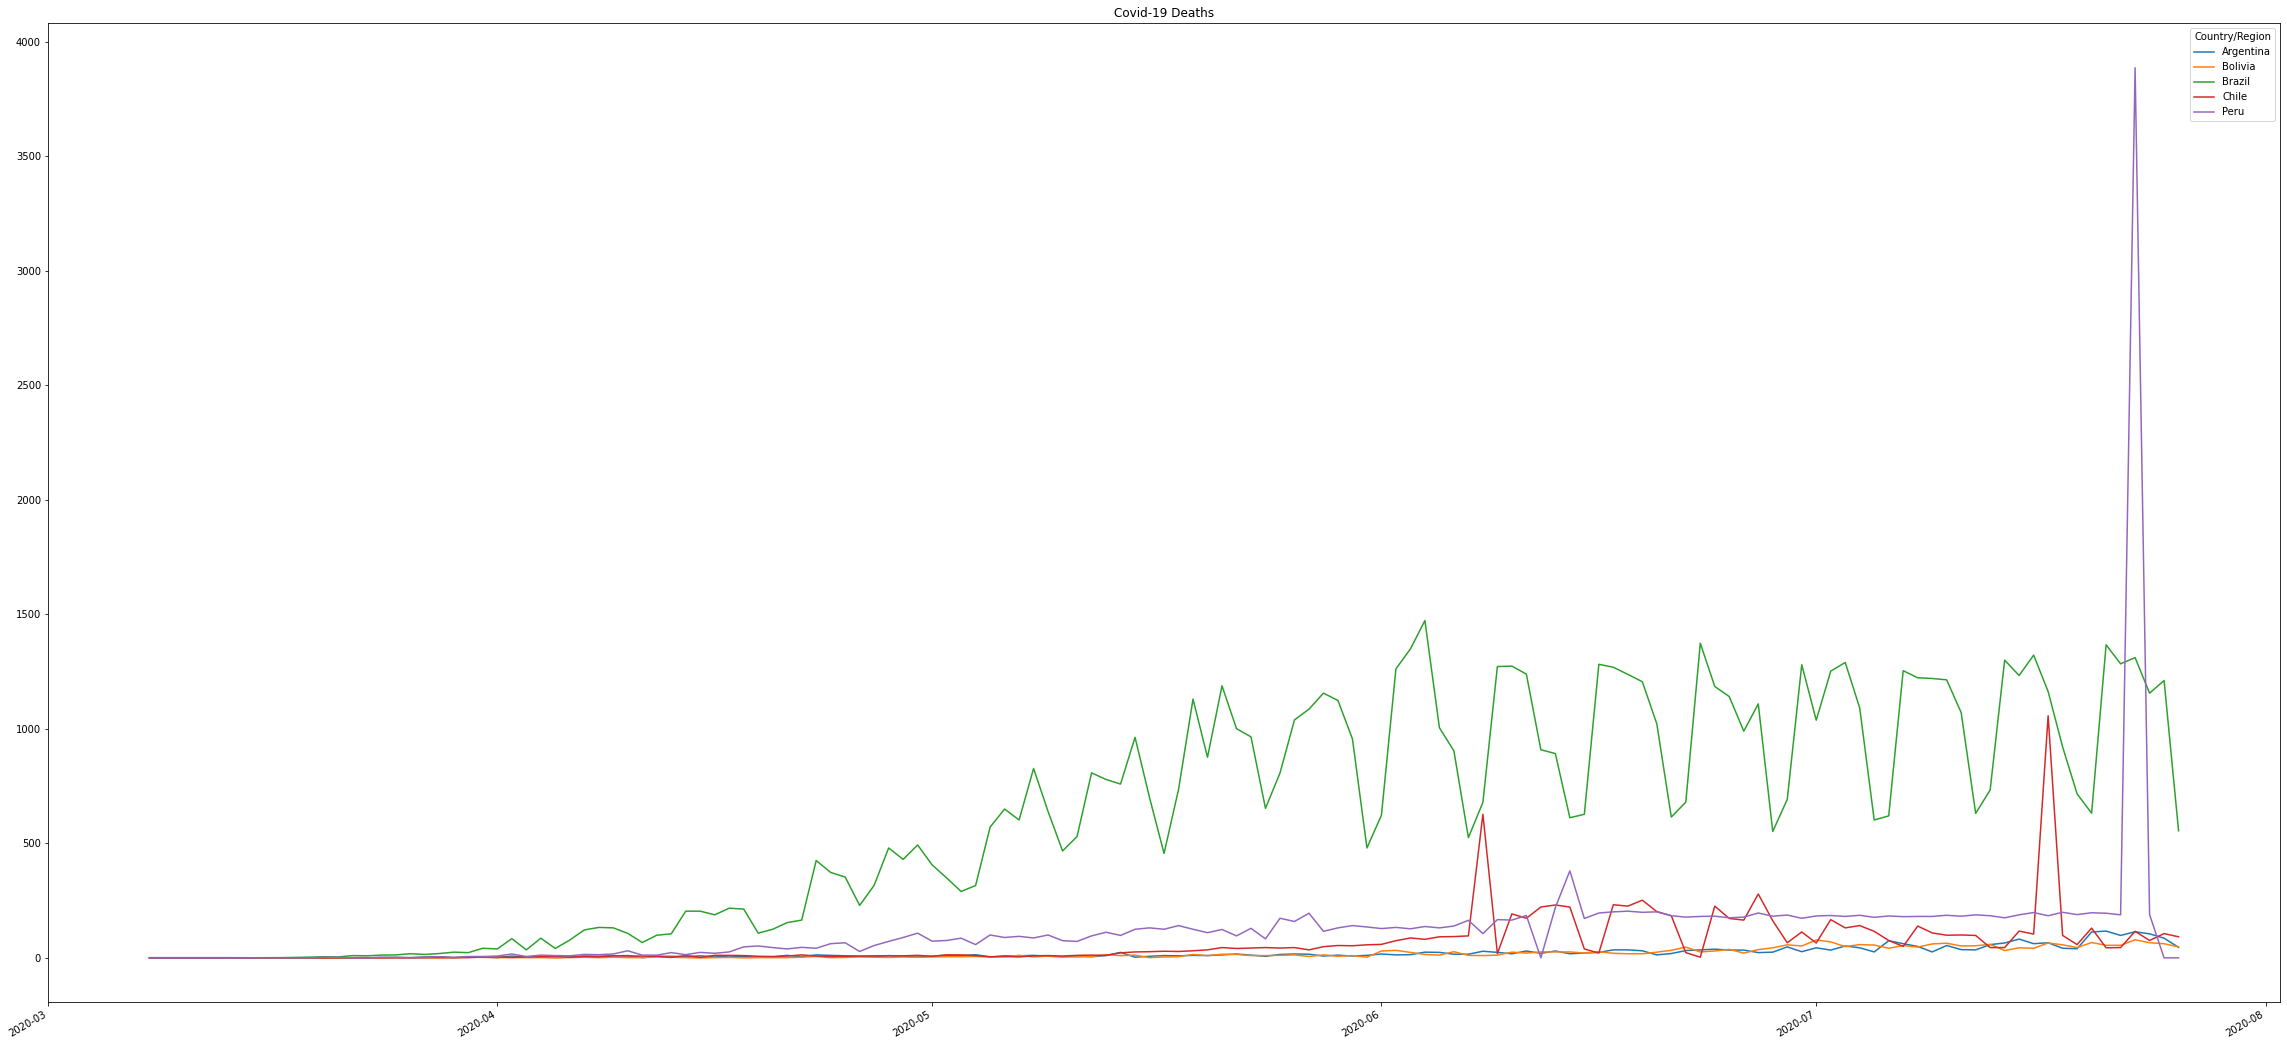

In [37]:
new_deaths_df.transpose().plot(kind='line', title='Covid-19 Deaths', logy=False)

## Create dataframe with selected countries and number of recovered patients per day

In [38]:
selected_recovered_df = get_selected_countries(recovered_df)
new_recovered_df = get_difference_between_days(selected_recovered_df)
new_recovered_df

,2020-03-14,2020-03-16,2020-03-17,2020-03-20,2020-03-22,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,...,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,1.0,0.0,2.0,0.0,0.0,49.0,0.0,11.0,9.0,0.0,0.0,156.0,12.0,8.0,8.0,10.0,13.0,1.0,45.0,13.0,20.0,7.0,10.0,65.0,28.0,47.0,44.0,37.0,35.0,35.0,19.0,24.0,28.0,103.0,32.0,47.0,57.0,54.0,77.0,33.0,...,338.0,209.0,1130.0,355.0,522.0,425.0,423.0,240.0,972.0,3628.0,727.0,991.0,1004.0,890.0,1012.0,1146.0,1038.0,706.0,1667.0,934.0,1564.0,6407.0,1811.0,671.0,2424.0,1286.0,1479.0,1294.0,1831.0,1822.0,660.0,2827.0,1498.0,1808.0,2685.0,1933.0,2284.0,2632.0,2575.0,2496.0
Bolivia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,7.0,12.0,5.0,0.0,0.0,6.0,7.0,0.0,10.0,0.0,26.0,18.0,...,250.0,0.0,668.0,416.0,368.0,403.0,443.0,495.0,543.0,398.0,422.0,359.0,411.0,412.0,424.0,594.0,408.0,506.0,395.0,262.0,469.0,485.0,471.0,564.0,415.0,510.0,451.0,525.0,538.0,622.0,903.0,318.0,353.0,322.0,415.0,431.0,309.0,584.0,337.0,218.0
Brazil,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,114.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,2873.0,10980.0,0.0,0.0,0.0,8104.0,0.0,861.0,2327.0,1255.0,1082.0,1505.0,992.0,990.0,...,31041.0,13534.0,17051.0,25148.0,11339.0,13618.0,26227.0,32506.0,19055.0,22875.0,25316.0,18303.0,11793.0,30507.0,29324.0,140050.0,26923.0,6116.0,38314.0,33497.0,44470.0,32832.0,31603.0,45914.0,26727.0,20755.0,26408.0,32174.0,26673.0,47433.0,30989.0,18888.0,11664.0,55228.0,41039.0,36636.0,28338.0,72901.0,92145.0,27554.0
Chile,0.0,0.0,0.0,6.0,2.0,9.0,5.0,0.0,21.0,18.0,14.0,81.0,0.0,78.0,101.0,92.0,101.0,90.0,110.0,170.0,217.0,159.0,297.0,293.0,195.0,308.0,279.0,291.0,362.0,322.0,414.0,303.0,338.0,293.0,417.0,418.0,523.0,419.0,278.0,303.0,...,25699.0,4510.0,5050.0,5118.0,3960.0,4828.0,5173.0,4523.0,4234.0,4104.0,4624.0,4155.0,3944.0,5075.0,4214.0,3804.0,4096.0,4108.0,3588.0,3339.0,3873.0,3490.0,3181.0,3131.0,3061.0,2788.0,2654.0,2664.0,2865.0,3216.0,1513.0,2635.0,2345.0,2198.0,2824.0,2425.0,2190.0,2265.0,2473.0,1926.0
Peru,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0,0.0,0.0,37.0,341.0,0.0,143.0,0.0,377.0,75.0,8.0,304.0,32.0,105.0,131.0,170.0,59.0,844.0,227.0,239.0,3012.0,421.0,143.0,127.0,157.0,14.0,45.0,395.0,74.0,301.0,291.0,337.0,...,3417.0,2568.0,4330.0,7497.0,0.0,3353.0,3117.0,3152.0,0.0,8581.0,4218.0,3974.0,3161.0,3376.0,3710.0,3852.0,3755.0,3769.0,4336.0,3662.0,3319.0,3810.0,3054.0,2836.0,3514.0,2959.0,3897.0,2253.0,3139.0,4594.0,2988.0,4104.0,3869.0,3126.0,3665.0,3500.0,3699.0,3478.0,0.0,8427.0


## Plot number of recovered patients per day

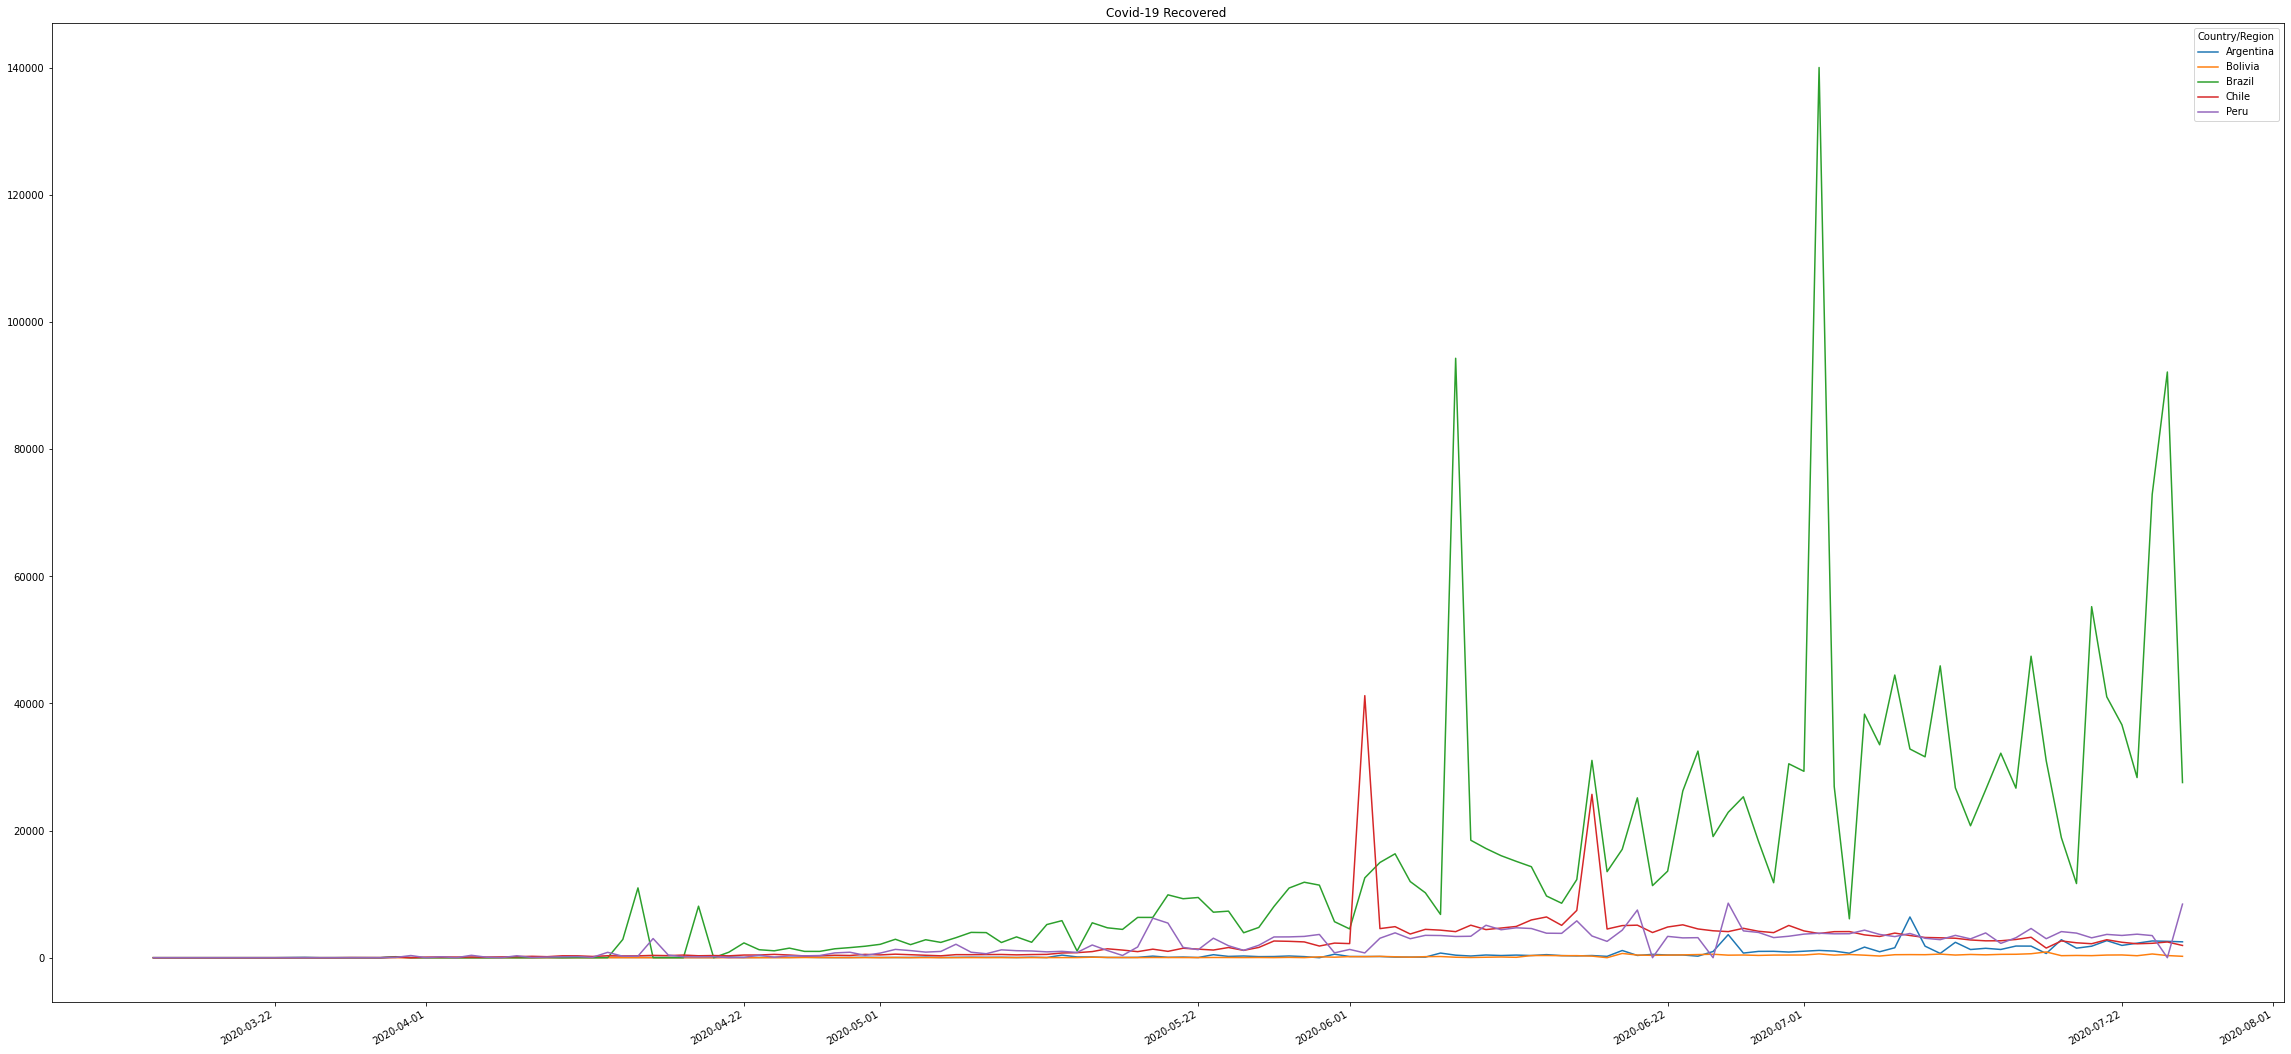

In [39]:
new_recovered_df.transpose().plot(kind='line', title='Covid-19 Recovered ', 
                                  logy=False)

## Calculate death rate based on all cases (recovered, deaths, still with Covid-19)

In [40]:
death_rate_vs_confirmed = selected_deaths_df.iloc[:,-1] \
                          / selected_confirmed_df.iloc[:,-1] 
death_rate_vs_confirmed

Country/Region
Argentina    0.018083
Bolivia      0.037203
Brazil       0.035966
Chile        0.026351
Peru         0.047460
Name: 2020-07-26 00:00:00, dtype: float64

## Calculate death rate based on number of recovered patients plus deaths

In [41]:
death_rate_vs_recovered = selected_deaths_df.iloc[:,-1] / \
                          (selected_recovered_df.iloc[:,-1] + \
                           selected_deaths_df.iloc[:,-1])
death_rate_vs_recovered

Country/Region
Argentina    0.040010
Bolivia      0.108749
Brazil       0.045794
Chile        0.027848
Peru         0.062455
Name: 2020-07-26 00:00:00, dtype: float64

## Calculate reproduction number 
Last four days vs. previous four days 

```Reff(t) = (N(t)+N(t-1)+N(t-2)+N(t-3)) / (N(t-4)+N(t-5)+N(t-6)+N(t-7))``` 

In [42]:
# divide new cases from last four days with new cases from previous four days
reproduction_df = (new_confirmed_df.iloc[:,-1] \
                   + new_confirmed_df.iloc[:,-2] \
                   + new_confirmed_df.iloc[:,-3] \
                   + new_confirmed_df.iloc[:,-4]) \
                  / (new_confirmed_df.iloc[:,-5] \
                   + new_confirmed_df.iloc[:,-6] \
                   + new_confirmed_df.iloc[:,-7] \
                   + new_confirmed_df.iloc[:,-8])
reproduction_df

Country/Region
Argentina    1.064513
Bolivia      0.882775
Brazil       1.254975
Chile        1.242456
Peru         0.551965
dtype: float64